# I'm from Bajookieland
Prepared by Ryan Birmingham for Deep Learning; DTSA 5511

# Motivation and Sources
Have you ever wanted to visit a country that does not exist? I'd hazard a guess that you have. Many people enjoy fantasy lands in books, games, movies, tv shows, and maybe just through an active imagination. However, it may be difficult to create a fake country border which both "looks right" to audiences, but also is not the same as any other existing country.

To this end, I'm working with a dataset of geospatial shape encodings of countries and states (accessed from https://www.kaggle.com/datasets/chapagain/country-state-geo-location) in geojson format. From this, we can train a GAN to output country shape data.

However, before this, I'll train and analyize a autoencoder to see how well this dataset compresses. This will give us some vague metric of the information density contained within the map data, which may help us get a good balance to avoid overtraining the GAN (and having a discriminator functionally memorize all countries, which is entirelly possible).

# The Data
I am using a kaggle notebook, and have added the "Country State GeoJSON" dataset directly. This, as a reminder, can be found at https://www.kaggle.com/datasets/chapagain/country-state-geo-location.

GeoJSON is a format that encodes geographic shape data in a (series) of loops line by line. While it's possible to use a text model to try to generate this, we probably want to convert this into an image format. This has the added benefit of sidestepping the very likely case where the model would not output valid geojson.

Anyway, what files do we have in the dataset?

In [2]:
import numpy as np
import pandas as pd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/country-state-geo-location/countries.geo.json
/kaggle/input/country-state-geo-location/us-states.json
/kaggle/input/country-state-geo-location/us-counties.json
/kaggle/input/country-state-geo-location/countries/BMU.geo.json
/kaggle/input/country-state-geo-location/countries/TUN.geo.json
/kaggle/input/country-state-geo-location/countries/MLT.geo.json
/kaggle/input/country-state-geo-location/countries/HRV.geo.json
/kaggle/input/country-state-geo-location/countries/BRN.geo.json
/kaggle/input/country-state-geo-location/countries/NGA.geo.json
/kaggle/input/country-state-geo-location/countries/MNG.geo.json
/kaggle/input/country-state-geo-location/countries/GNB.geo.json
/kaggle/input/country-state-geo-location/countries/SOM.geo.json
/kaggle/input/country-state-geo-location/countries/PNG.geo.json
/kaggle/input/country-state-geo-location/countries/IRN.geo.json
/kaggle/input/country-state-geo-location/countries/BGD.geo.json
/kaggle/input/country-state-geo-location/countries/FRA.geo

Let's look at a truncated example of the format, then see if we can plot some.

In [3]:
!head /kaggle/input/country-state-geo-location/countries/BFA.geo.json

{"type":"FeatureCollection","features":[
{"type":"Feature","id":"BFA","properties":{"name":"Burkina Faso"},"geometry":{"type":"Polygon","coordinates":[[[-2.827496,9.642461],[-3.511899,9.900326],[-3.980449,9.862344],[-4.330247,9.610835],[-4.779884,9.821985],[-4.954653,10.152714],[-5.404342,10.370737],[-5.470565,10.95127],[-5.197843,11.375146],[-5.220942,11.713859],[-4.427166,12.542646],[-4.280405,13.228444],[-4.006391,13.472485],[-3.522803,13.337662],[-3.103707,13.541267],[-2.967694,13.79815],[-2.191825,14.246418],[-2.001035,14.559008],[-1.066363,14.973815],[-0.515854,15.116158],[-0.266257,14.924309],[0.374892,14.928908],[0.295646,14.444235],[0.429928,13.988733],[0.993046,13.33575],[1.024103,12.851826],[2.177108,12.625018],[2.154474,11.94015],[1.935986,11.64115],[1.447178,11.547719],[1.24347,11.110511],[0.899563,10.997339],[0.023803,11.018682],[-0.438702,11.098341],[-0.761576,10.93693],[-1.203358,11.009819],[-2.940409,10.96269],[-2.963896,10.395335],[-2.827496,9.642461]]]}}
]}


In [4]:
import geopandas
import os
import random

all_files = []
files_to_render = []

for filename in os.scandir("/kaggle/input/country-state-geo-location/countries/"):
    if filename.is_file():
        if len(filename.path.split("."))>1 and filename.path.split(".")[1] == "geo":
            all_files.append(filename.path)
            # only show about 5 percent
            if random.random() > 0.95: 
                files_to_render.append(filename.path)

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [5]:
print("total geojson documents", len(all_files))
print("of those, randomly selected", len(files_to_render))

total geojson documents 178
of those, randomly selected 9


Japan
Laos
Tajikistan
Finland
Saudi Arabia
Nepal
New Caledonia
Germany
Poland


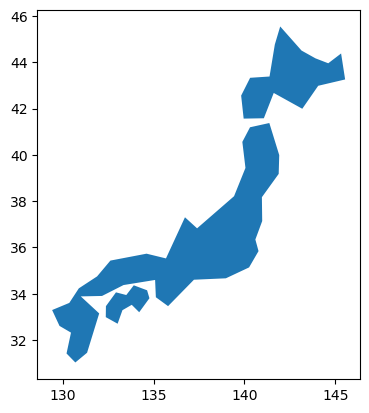

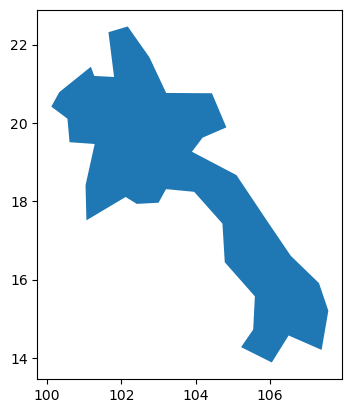

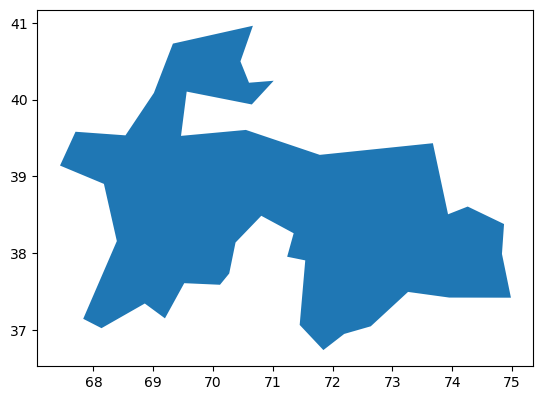

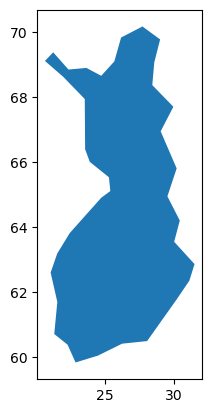

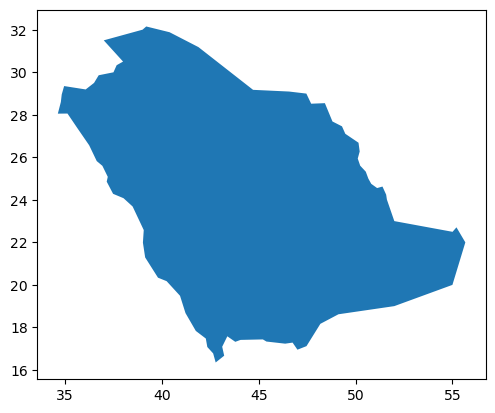

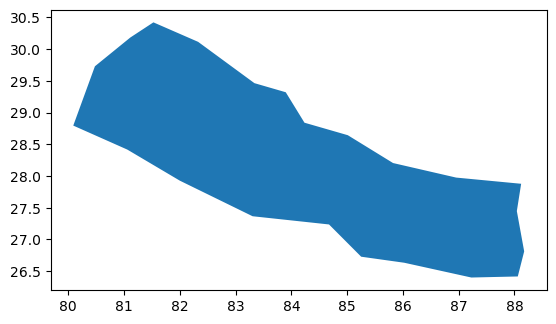

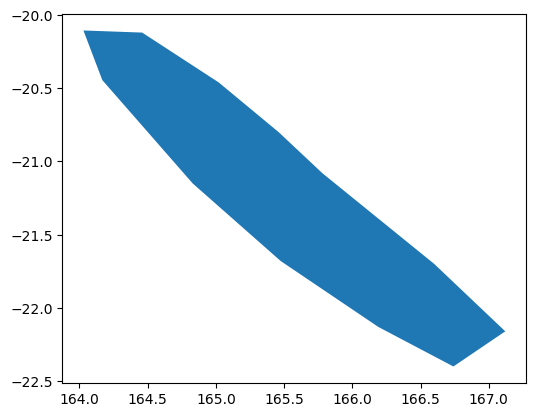

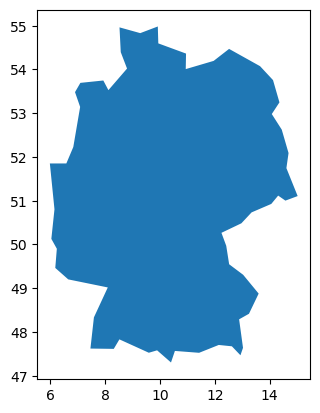

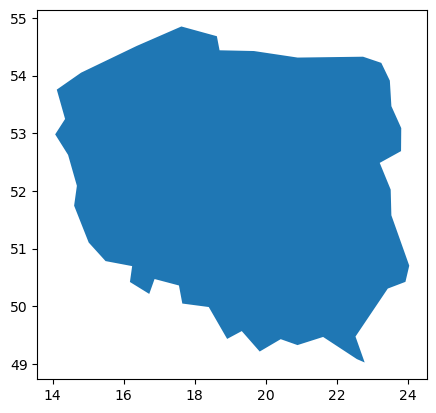

In [16]:
for fp in files_to_render:
    geo_data = geopandas.GeoDataFrame.from_file(fp)
    geo_data.plot()
    print(geo_data['name'][0])

The dataset doesn't have extremely detailed line data, which is unfortunate.

## Further Prepocessing Needed
This is a lucky break. However, to make future steps easier, I want to change the plot method to make something closer to training data.
I want the plot size to be consistent, and I don't want those axes.
Thankfully, pyplot is easy to manipulate as such.
Let's test something on these same countries.

In [7]:
import matplotlib.pyplot as plt

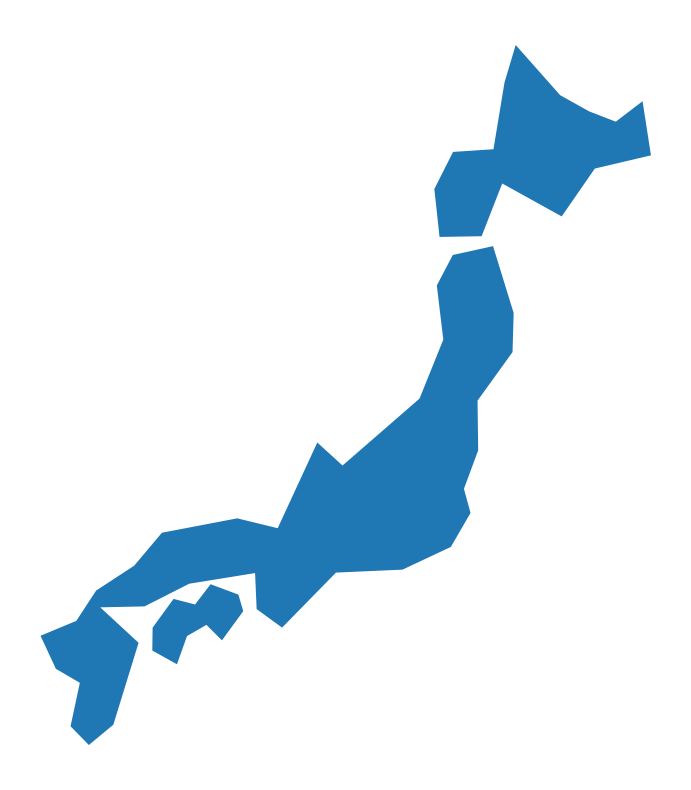

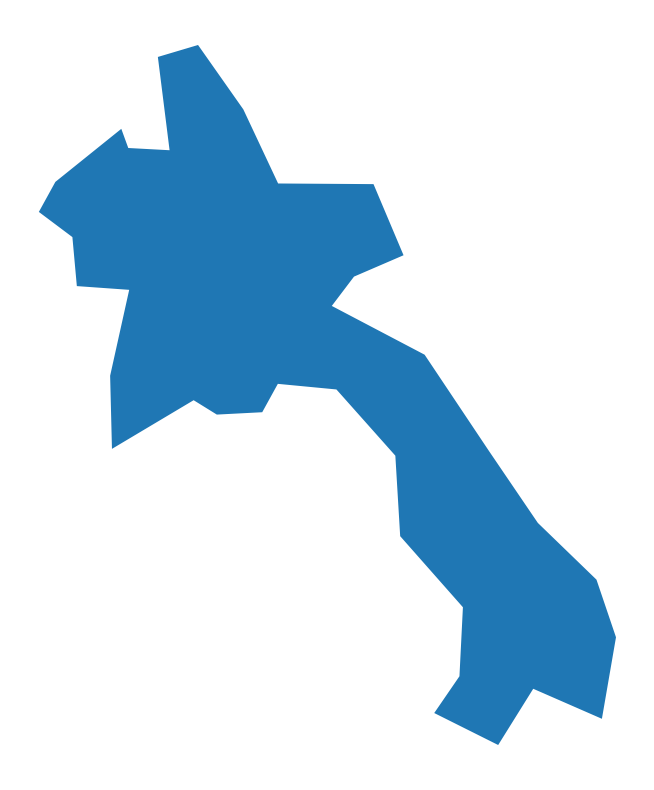

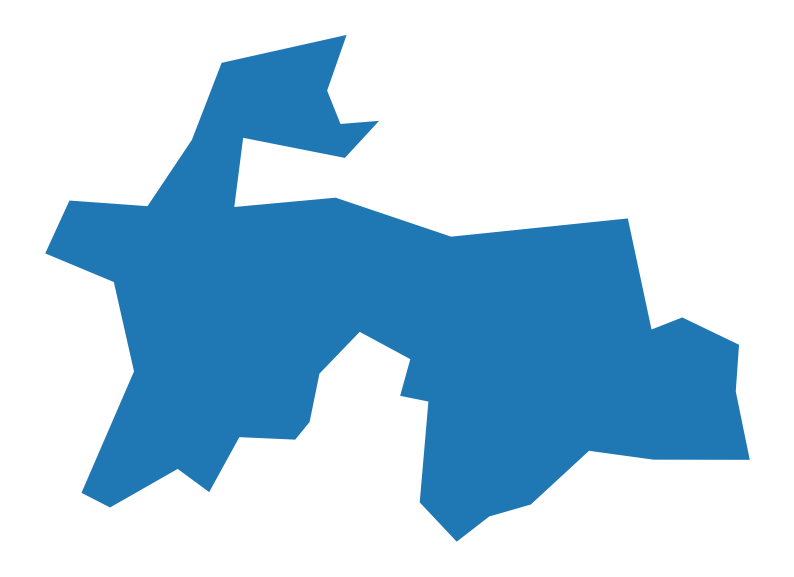

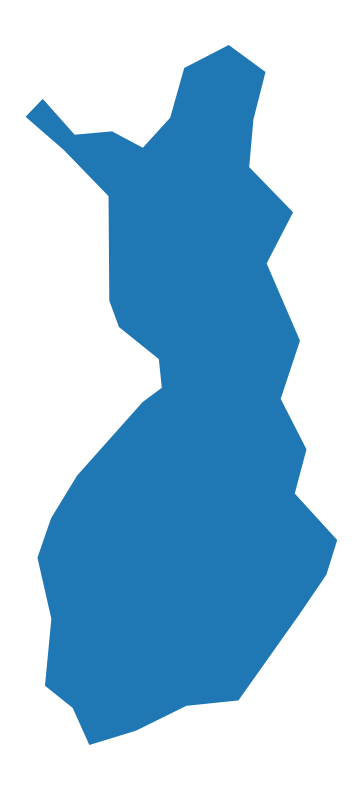

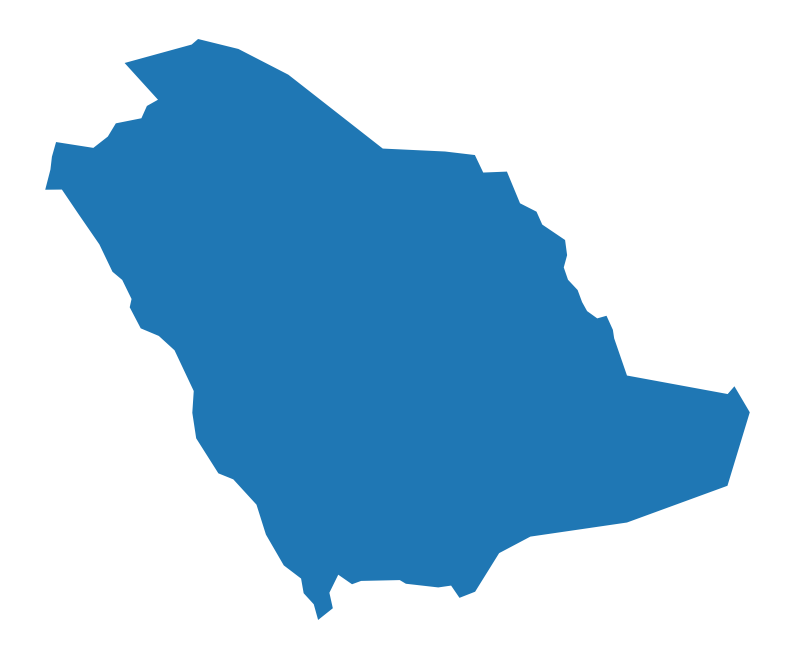

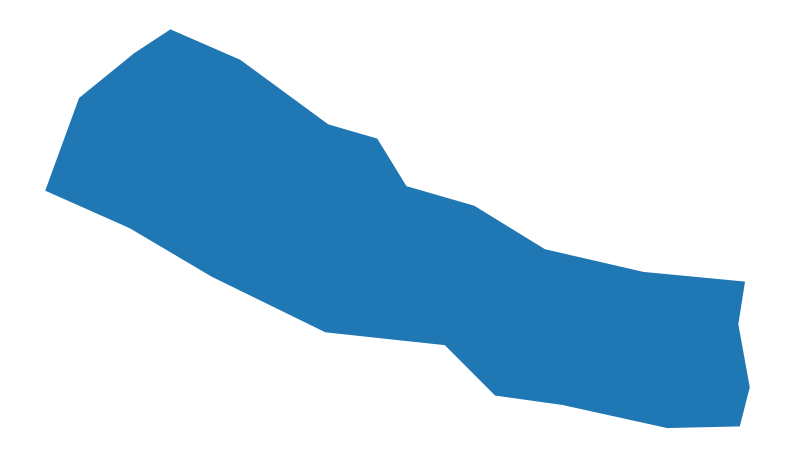

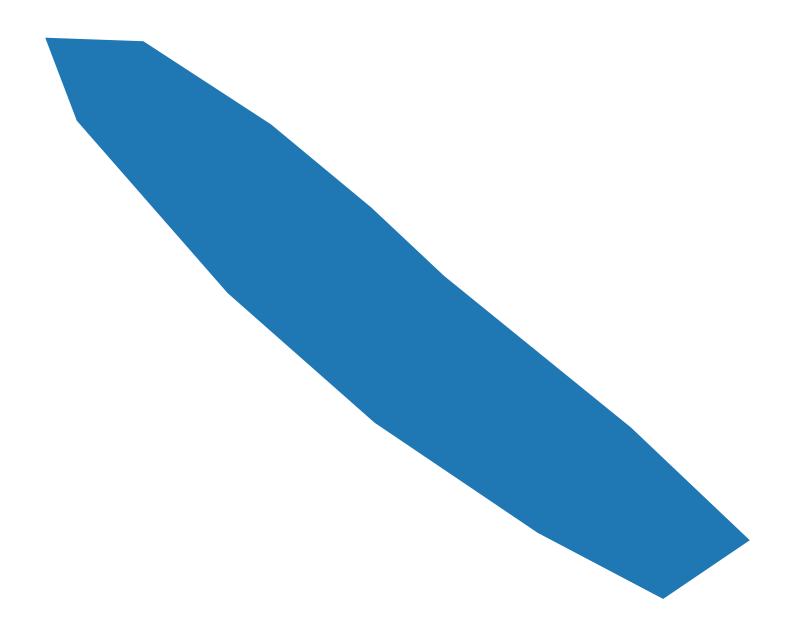

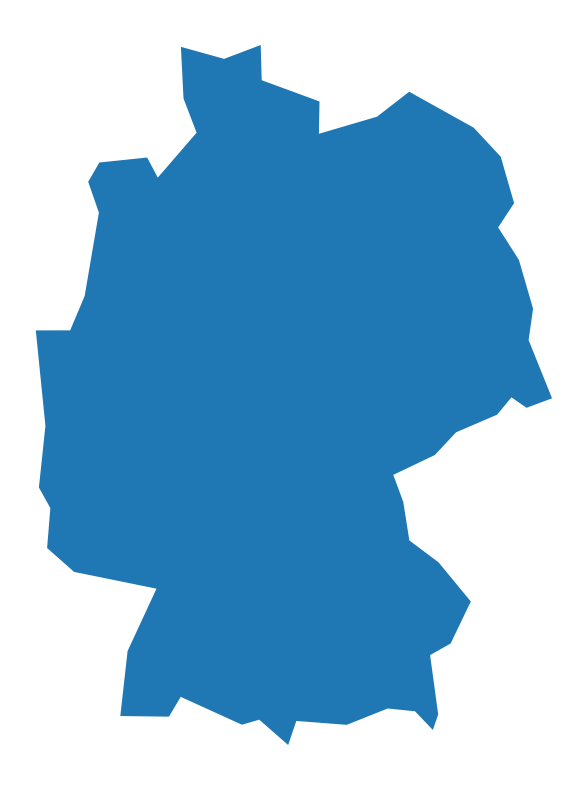

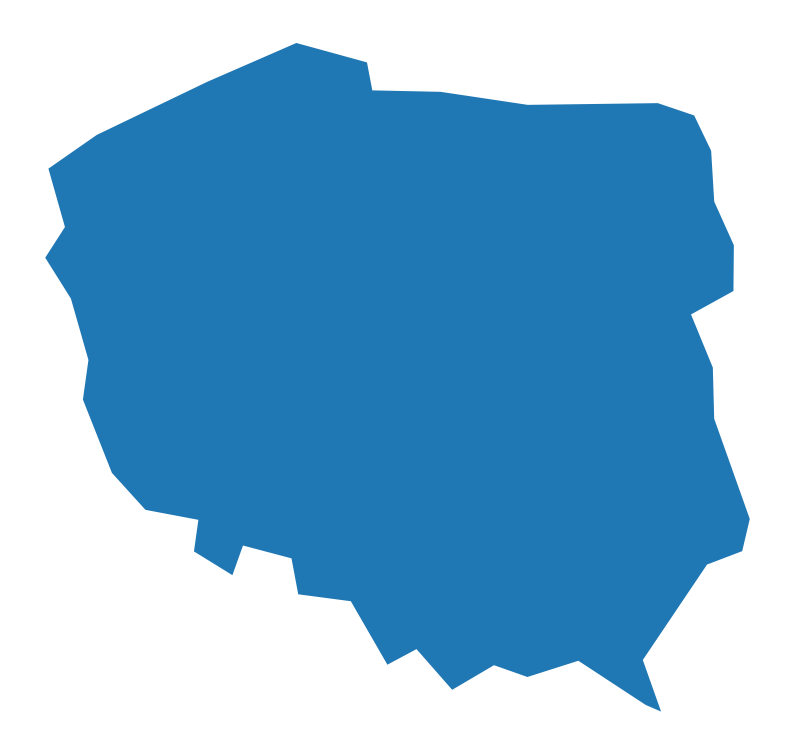

In [22]:
for fp in files_to_render:
    geo_data = geopandas.GeoDataFrame.from_file(fp)
    geo_plot = geo_data.plot(figsize=(10,10))
    geo_plot.grid(False)
    geo_plot.axis('off')

# Creating the dataset
Now that we have a good way to generate these images, let's generate them.

In [37]:
# remove old data as needed
! rm *.png


In [38]:

for fp in all_files:
    geo_data = geopandas.GeoDataFrame.from_file(fp)
    dest_fn = geo_data['name'][0] + ".png"
    geo_data.plot(figsize=(10,10))
    plt.grid(False)
    plt.axis('off')
    plt.savefig(dest_fn)
    plt.close()

Let's look at a few of the saved images to confirm.

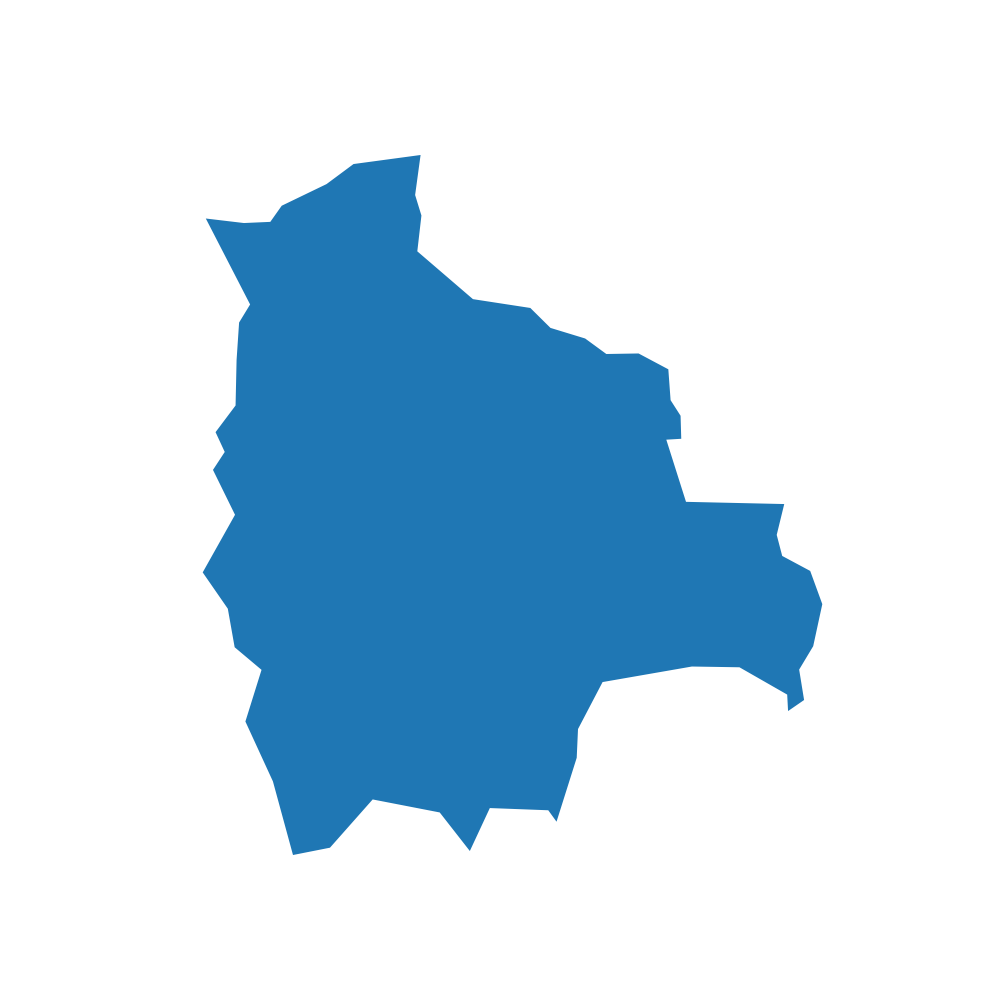

In [39]:
from IPython.display import Image
Image(filename="Bolivia.png") 

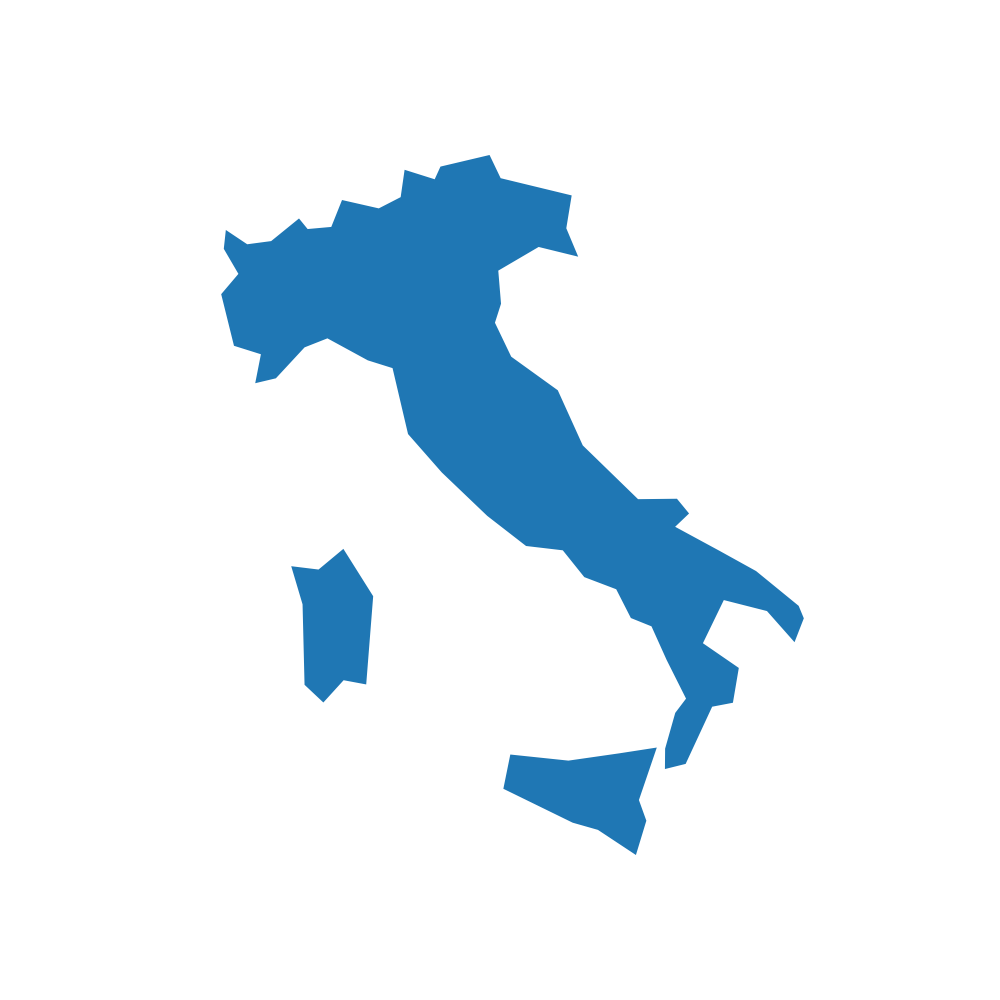

In [40]:
Image(filename="Italy.png") 

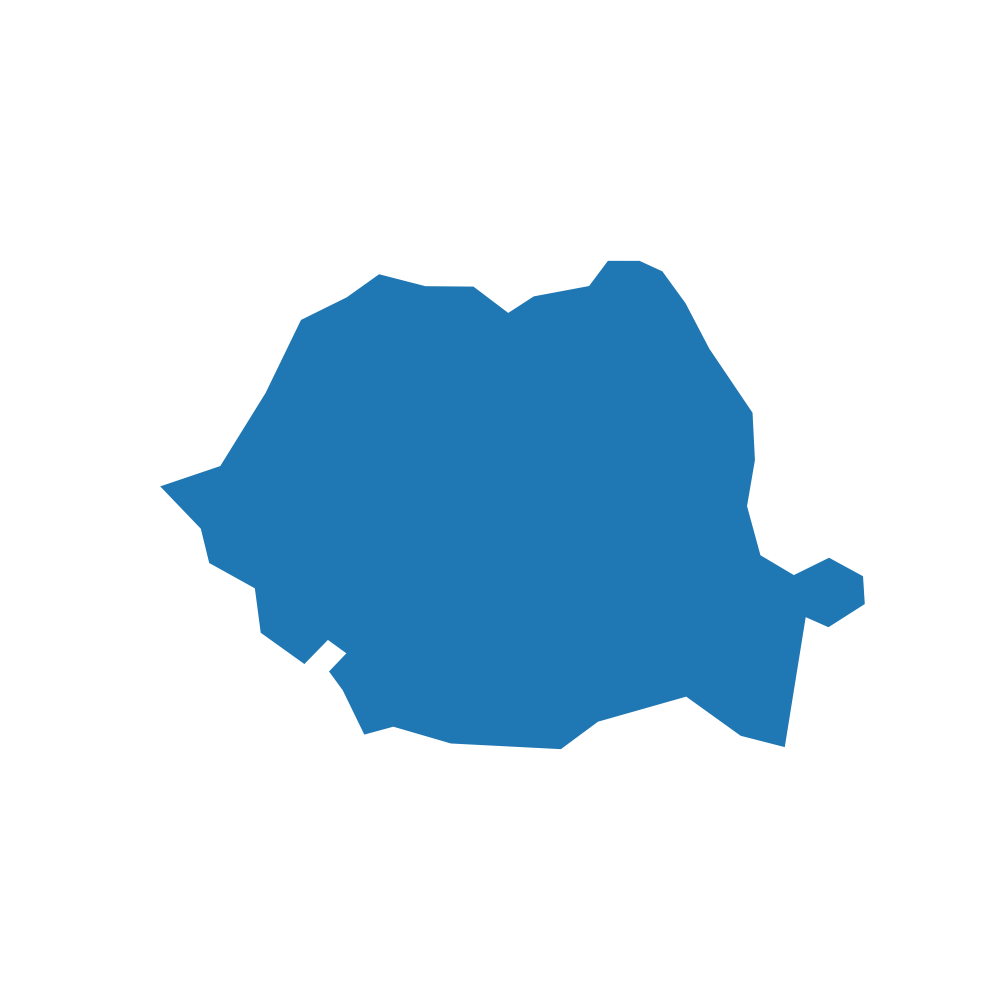

In [41]:
Image(filename="Romania.png") 

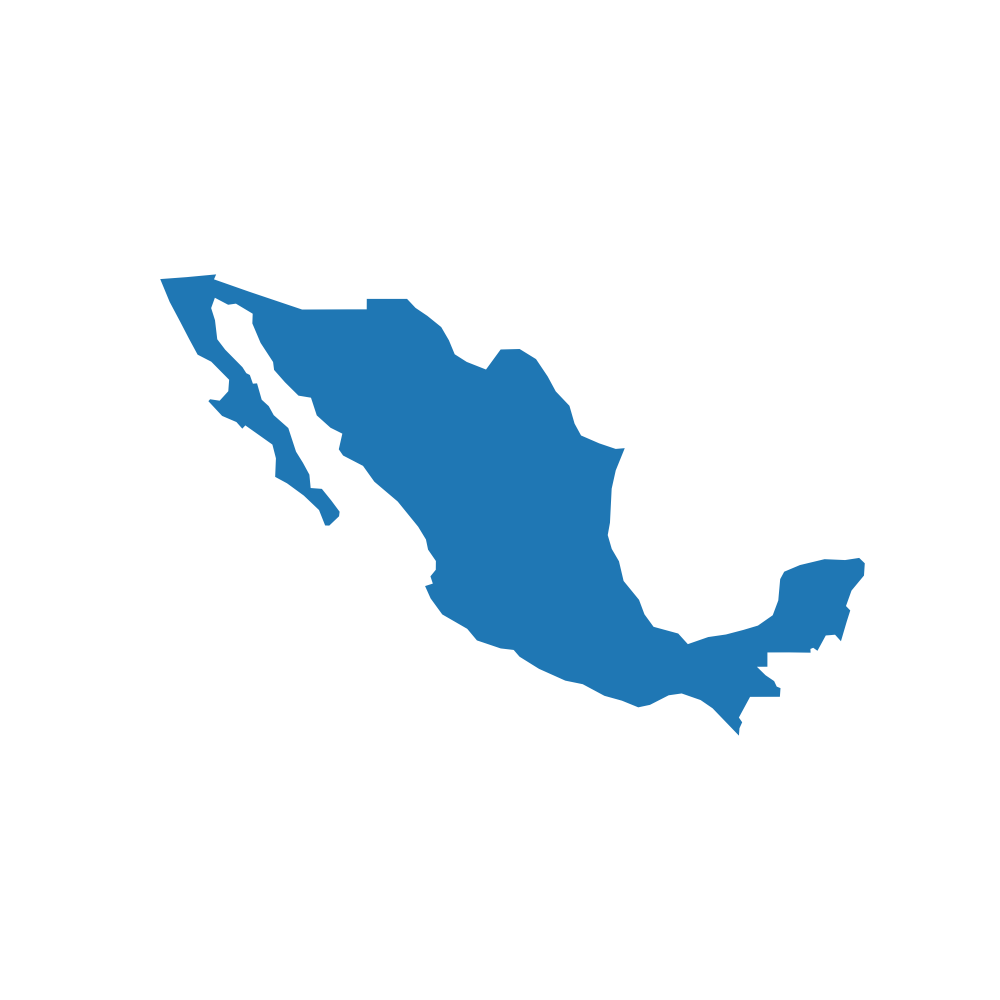

In [43]:
Image(filename="Mexico.png") 

# Checking in on our data progress.

So, we've created a dataset of shape images of various contries. We need to now create an image dataset in keras for both of our model approaches. We're doing unsupervised deep learning here, so we don't need any labels (yet).

In [44]:
import tensorflow as tf

In [119]:
map_validation = tf.keras.utils.image_dataset_from_directory("/kaggle/working/", label_mode=None, batch_size=32, seed=420, subset='validation', validation_split=0.1)
map_train = tf.keras.utils.image_dataset_from_directory("/kaggle/working/", label_mode=None, batch_size=32, seed=420, subset="training", validation_split=0.1)

Found 178 files belonging to 1 classes.
Using 17 files for validation.
Found 178 files belonging to 1 classes.
Using 161 files for training.


In [76]:
# let's quickly confirm that matches our expectation.
! ls -l *.png | wc -l

178


In [120]:
# black and white and resize
map_validation = map_validation.map(lambda img: tf.keras.preprocessing.image.smart_resize(img, (64,64)))
map_validation = map_validation.map(lambda x: tf.math.reduce_mean(x, axis=3))
map_validation = map_validation.map(lambda x: tf.expand_dims(x, axis=3))
map_validation = map_validation.map(lambda x: x / 255.0)

map_train = map_train.map(lambda img: tf.keras.preprocessing.image.smart_resize(img, (64,64)))
map_train = map_train.map(lambda x: tf.math.reduce_mean(x, axis=3))
map_train = map_train.map(lambda x: tf.expand_dims(x, axis=3))
map_train = map_train.map(lambda x: x / 255.0)

# The Model Part 1: Autoencoder

The first thing we want to do is determine is the information density. Let's satisfy the hyperparameter tuning by comparing different params for VAE. Namely, the latent dimension. Let's start by 8x8:


In [78]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [147]:
# with inspiration from https://blog.keras.io/building-autoencoders-in-keras.html

input_img = keras.Input(shape=(64, 64, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (4, 4), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_69 (Conv2D)          (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 16, 16, 8)         584

In [161]:
# getting around a "dataset" problem
def change_inputs(images):
  x = tf.image.resize(images,[64, 64], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  print(x.shape)
  return x, x

X_train = map_train.map(change_inputs)
X_test = map_validation.map(change_inputs)

(None, 64, 64, 1)
(None, 64, 64, 1)


In [148]:
autoenc_history = autoencoder.fit(X_train,
                epochs=50,
                batch_size=32,
                validation_data=X_test,
                shuffle=True)

(None, 64, 64, 1)
(None, 64, 64, 1)
Epoch 1/50
6/6 [==============================] - 3s 197ms/step - loss: 0.6554 - val_loss: 0.5614
Epoch 2/50
6/6 [==============================] - 2s 156ms/step - loss: 0.4793 - val_loss: 0.4122
Epoch 3/50
6/6 [==============================] - 2s 156ms/step - loss: 0.3939 - val_loss: 0.4523
Epoch 4/50
6/6 [==============================] - 2s 157ms/step - loss: 0.3739 - val_loss: 0.3844
Epoch 5/50
6/6 [==============================] - 2s 156ms/step - loss: 0.3478 - val_loss: 0.3707
Epoch 6/50
6/6 [==============================] - 2s 152ms/step - loss: 0.3302 - val_loss: 0.3528
Epoch 7/50
6/6 [==============================] - 2s 151ms/step - loss: 0.3076 - val_loss: 0.3247
Epoch 8/50
6/6 [==============================] - 2s 156ms/step - loss: 0.2845 - val_loss: 0.3011
Epoch 9/50
6/6 [==============================] - 2s 155ms/step - loss: 0.2634 - val_loss: 0.2822
Epoch 10/50
6/6 [==============================] - 2s 154ms/step - loss: 0.2440 - 

In [155]:
# what makes sense to visualize?
autoenc_history.history.keys()

dict_keys(['loss', 'val_loss'])

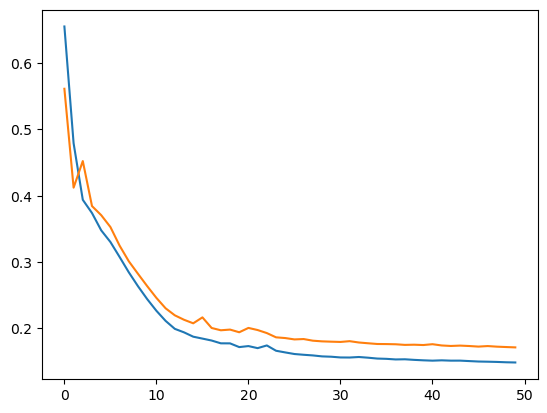

In [156]:
plt.plot(autoenc_history.history['loss'])
plt.plot(autoenc_history.history['val_loss'])

That looks pretty reasonable. What do the reconstructions look like?

1/1 [==============================] - 0s 226ms/step


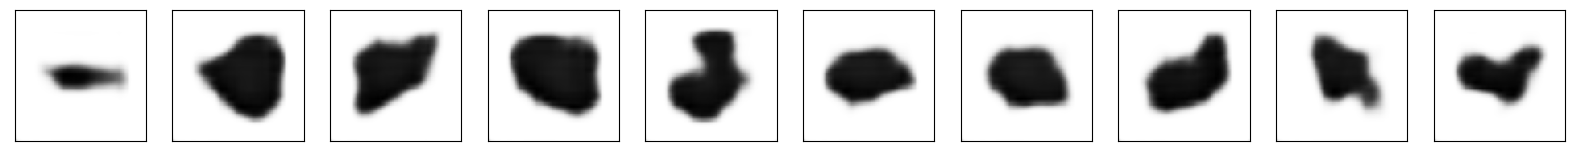

In [158]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Trying to "get the loss higher"
Let's try a much smaller latent dimension. Will this noticable increase loss? If so, it would tell us about how the data is represented. Let's try 4x4, 4x the compression of the 8x8, and 256x the compression of the original

In [162]:
# latent dimensions changed to 4x4.
# with inspiration from https://blog.keras.io/building-autoencoders-in-keras.html

input_img = keras.Input(shape=(64, 64, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (4, 4), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_4 = keras.Model(input_img, decoded)
autoencoder_4.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_4.summary()

autoenc_4_history = autoencoder_4.fit(X_train,
                epochs=50,
                batch_size=32,
                validation_data=X_test,
                shuffle=True)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_92 (Conv2D)          (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_94 (Conv2D)          (None, 16, 16, 8)         584

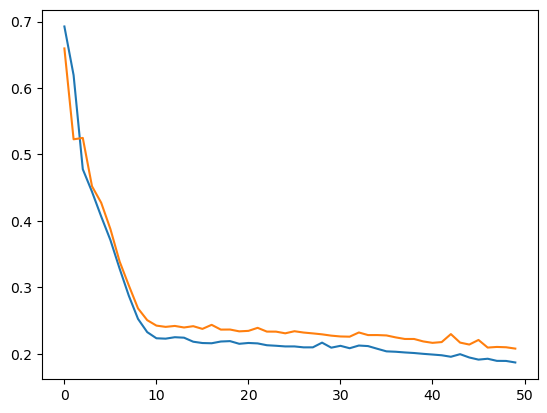

In [163]:
plt.plot(autoenc_4_history.history['loss'])
plt.plot(autoenc_4_history.history['val_loss'])

1/1 [==============================] - 0s 327ms/step


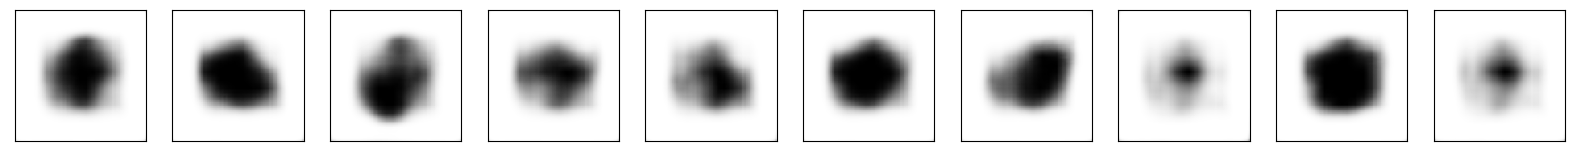

In [164]:
decoded_imgs = autoencoder_4.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

They do look quite blurry, but still retain some of the original shapes.

# Discussion and Conclusion of the Autoencoder Work
Interestingly, the autoencoder did not have much more loss even when the decoded images are much worse for practical purposes. I think that this means that my original attempt to use autoencoder dimension versus loss does not work as expected to understand a heuristic for the information density of the country data.

# Model part 2 - the GAN.
Let's use a conditional gan now to try to make imaginary countries (shapes). This is useful as it's a reasonably simple GAN. The ability for it to use a random vector is closest to our use case. We're not trying to style transfer, rather "extend" a dataset. 

In [175]:
# With help with the keras docs at https://keras.io/examples/generative/dcgan_overriding_train_step/

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 1)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

generator = tf.keras.Sequential(
    [
        keras.Input(shape=(64,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_113 (Conv2D)         (None, 32, 32, 64)        1088      
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_114 (Conv2D)         (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_115 (Conv2D)         (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 flatten_6 (Flatten)         (None, 8192)            

In [182]:
# put images here made midway through training!
! mkdir monitoring

In [189]:
# heavily borrowed from keras docs at https://keras.io/examples/generative/dcgan_overriding_train_step/

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=64):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        # how man images to generate
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            fn = "monitoring/generated_img_%03d_%d.png" % (epoch, i)
            img.save(fn)
            # show it
            Image(filename=fn)

In [178]:
# dataset for gan training
map_data = tf.keras.utils.image_dataset_from_directory("/kaggle/working/", label_mode=None, batch_size=32)
# black and white and resize
map_data = map_data.map(lambda img: tf.keras.preprocessing.image.smart_resize(img, (64,64)))
map_data = map_data.map(lambda x: tf.math.reduce_mean(x, axis=3))
map_data = map_data.map(lambda x: tf.expand_dims(x, axis=3))
map_data = map_data.map(lambda x: x / 255.0)

Found 178 files belonging to 1 classes.


In [190]:
epochs = 33

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=64)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    map_data, epochs=epochs, callbacks=[GANMonitor(num_img=2, latent_dim=64)]
)

Epoch 1/33
6/6 [==============================] - 74s 12s/step - d_loss: 0.3298 - g_loss: 1.2574
Epoch 2/33
6/6 [==============================] - 72s 12s/step - d_loss: 0.3019 - g_loss: 1.2311
Epoch 3/33
6/6 [==============================] - 72s 12s/step - d_loss: 0.3077 - g_loss: 1.3702
Epoch 4/33
6/6 [==============================] - 72s 12s/step - d_loss: 0.4069 - g_loss: 0.8931
Epoch 5/33
6/6 [==============================] - 72s 12s/step - d_loss: 0.5267 - g_loss: 0.6410
Epoch 6/33
6/6 [==============================] - 72s 12s/step - d_loss: 0.4920 - g_loss: 0.6055
Epoch 7/33
6/6 [==============================] - 73s 12s/step - d_loss: 0.4511 - g_loss: 0.6771
Epoch 8/33
6/6 [==============================] - 72s 12s/step - d_loss: 0.4268 - g_loss: 0.7325
Epoch 9/33
6/6 [==============================] - 72s 12s/step - d_loss: 0.3925 - g_loss: 0.7685
Epoch 10/33
6/6 [==============================] - 73s 12s/step - d_loss: 0.3580 - g_loss: 0.9381
Epoch 11/33
6/6 [============

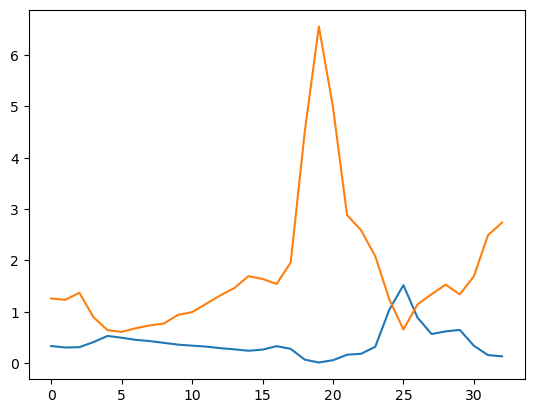

In [193]:
# plot loss for discriminator and generator
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])

showing /kaggle/working/monitoring/generated_img_005_0.png


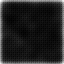

showing /kaggle/working/monitoring/generated_img_017_1.png


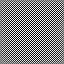

showing /kaggle/working/monitoring/generated_img_030_0.png


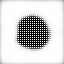

showing /kaggle/working/monitoring/generated_img_019_0.png


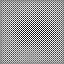

showing /kaggle/working/monitoring/generated_img_023_0.png


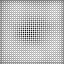

showing /kaggle/working/monitoring/generated_img_026_0.png


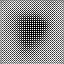

showing /kaggle/working/monitoring/generated_img_002_0.png


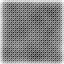

showing /kaggle/working/monitoring/generated_img_015_0.png


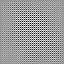

showing /kaggle/working/monitoring/generated_img_008_1.png


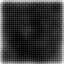

showing /kaggle/working/monitoring/generated_img_000_1.png


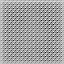

showing /kaggle/working/monitoring/generated_img_003_1.png


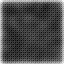

showing /kaggle/working/monitoring/generated_img_026_1.png


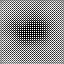

showing /kaggle/working/monitoring/generated_img_031_1.png


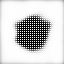

showing /kaggle/working/monitoring/generated_img_029_1.png


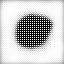

showing /kaggle/working/monitoring/generated_img_000_0.png


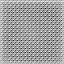

showing /kaggle/working/monitoring/generated_img_029_0.png


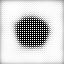

showing /kaggle/working/monitoring/generated_img_017_0.png


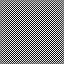

showing /kaggle/working/monitoring/generated_img_016_1.png


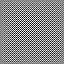

showing /kaggle/working/monitoring/generated_img_032_0.png


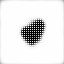

showing /kaggle/working/monitoring/generated_img_028_1.png


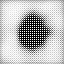

showing /kaggle/working/monitoring/generated_img_004_0.png


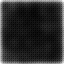

showing /kaggle/working/monitoring/generated_img_018_0.png


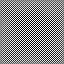

showing /kaggle/working/monitoring/generated_img_022_1.png


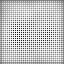

showing /kaggle/working/monitoring/generated_img_015_1.png


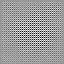

showing /kaggle/working/monitoring/generated_img_001_0.png


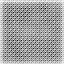

showing /kaggle/working/monitoring/generated_img_023_1.png


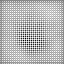

showing /kaggle/working/monitoring/generated_img_006_1.png


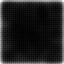

showing /kaggle/working/monitoring/generated_img_025_1.png


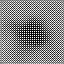

showing /kaggle/working/monitoring/generated_img_012_1.png


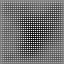

showing /kaggle/working/monitoring/generated_img_020_0.png


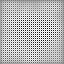

showing /kaggle/working/monitoring/generated_img_016_0.png


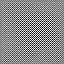

showing /kaggle/working/monitoring/generated_img_025_0.png


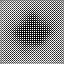

showing /kaggle/working/monitoring/generated_img_020_1.png


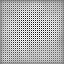

showing /kaggle/working/monitoring/generated_img_011_0.png


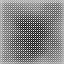

showing /kaggle/working/monitoring/generated_img_024_1.png


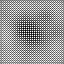

showing /kaggle/working/monitoring/generated_img_027_0.png


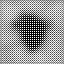

showing /kaggle/working/monitoring/generated_img_004_1.png


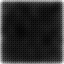

showing /kaggle/working/monitoring/generated_img_024_0.png


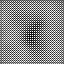

showing /kaggle/working/monitoring/generated_img_022_0.png


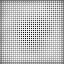

showing /kaggle/working/monitoring/generated_img_002_1.png


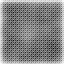

showing /kaggle/working/monitoring/generated_img_014_1.png


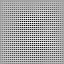

showing /kaggle/working/monitoring/generated_img_021_1.png


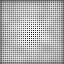

showing /kaggle/working/monitoring/generated_img_009_0.png


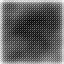

showing /kaggle/working/monitoring/generated_img_007_1.png


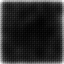

showing /kaggle/working/monitoring/generated_img_014_0.png


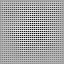

showing /kaggle/working/monitoring/generated_img_008_0.png


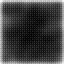

showing /kaggle/working/monitoring/generated_img_018_1.png


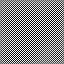

showing /kaggle/working/monitoring/generated_img_006_0.png


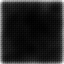

showing /kaggle/working/monitoring/generated_img_010_1.png


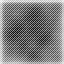

showing /kaggle/working/monitoring/generated_img_019_1.png


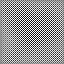

showing /kaggle/working/monitoring/generated_img_005_1.png


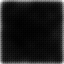

showing /kaggle/working/monitoring/generated_img_009_1.png


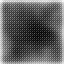

showing /kaggle/working/monitoring/generated_img_028_0.png


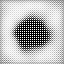

showing /kaggle/working/monitoring/generated_img_030_1.png


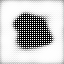

showing /kaggle/working/monitoring/generated_img_001_1.png


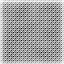

showing /kaggle/working/monitoring/generated_img_013_0.png


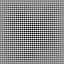

showing /kaggle/working/monitoring/generated_img_021_0.png


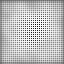

showing /kaggle/working/monitoring/generated_img_013_1.png


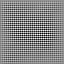

showing /kaggle/working/monitoring/generated_img_007_0.png


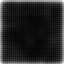

showing /kaggle/working/monitoring/generated_img_012_0.png


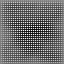

showing /kaggle/working/monitoring/generated_img_010_0.png


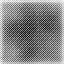

showing /kaggle/working/monitoring/generated_img_032_1.png


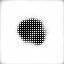

showing /kaggle/working/monitoring/generated_img_003_0.png


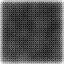

showing /kaggle/working/monitoring/generated_img_011_1.png


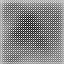

showing /kaggle/working/monitoring/generated_img_027_1.png


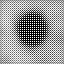

showing /kaggle/working/monitoring/generated_img_031_0.png


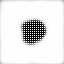

In [191]:
for filename in os.scandir("/kaggle/working/monitoring/"):
    if filename.is_file():
        print("showing", filename.path)
        display(Image(filename=filename.path))

# GAN Discussion and Conclusions 
(Note that conclusions for the Autoencoder section are with that section of the notebook)

After 33 epochs, unfortunately, the images are not quite good enough on their own. However, they are beginning to approach country-like shapes, albeit with some odd artifacts. I believe that this model is promising, since the generator and discriminator losses are reasonably close to each other, and seem to be evolving together.

Further work would involve trying to understand the artifacts, as well as training further, and on images which have not been downscaled as much.